# Quafu document
## Installation

Run following codes in command line
```shell
git clone https://github.com/ScQ-Cloud/quafu
cd quafu
python setup.py install
```

## Getting started

Initialize a circuit with 5 qubits 

In [1]:
import numpy as np
from quafu import QuantumCircuit

q = QuantumCircuit(4)

Add quantum gates, currently Quafu supports gates x, y, z, h, rx, ry, rz, cnot, cz, swap.

In [2]:
q.x(0)
q.x(1) 
q.cnot(2, 1) 
q.ry(1, np.pi/2) 
q.rx(2, np.pi) 
q.rz(3, 0.1) 
q.cz(2, 3) 

Add measurement information including qubits measured (measures), single shot number (shots) and classical bits keeping the measured results (cbits). If there is no measurement information provided, all qubits are measured by default.  

In [3]:
measures = [0, 1, 2, 3]
shots = 1000
cbits = [0, 1, 2, 3]
q.measure(measures, shots, cbits=cbits)

You can draw the circuit using the draw_circuit() method

In [4]:
q.draw_circuit()

0 -----X-------------------------- M->c[0]
                                  
1 -----X-------+---Ry(1.571)------ M->c[1]
               |                  
2 -------------*---Rx(3.142)---*-- M->c[2]
                               Cz 
3 -Rz(0.100)-------------------+-- M->c[3]


Set experiment backend and send the quantum circuit. The default backend is "ScQ-P10". You can use the "compile" parameter to tell the backend whether compile the circuit. If you want to run the circuit directly on the backend, set "compile" to false.

In [5]:
q.set_backend("ScQ-P10")
res = q.send(compile=True)

You can use the returned results to check the count and amplitude on each measured bit string. The output bits are arranged as 0, 1, 2,... from left to the right.

{'0010': 10, '0111': 6, '1000': 16, '1010': 484, '1100': 9, '1101': 1, '1110': 473, '1111': 1}
{'0010': 0.01, '0111': 0.006, '1000': 0.016, '1010': 0.484, '1100': 0.009, '1101': 0.001, '1110': 0.473, '1111': 0.001}


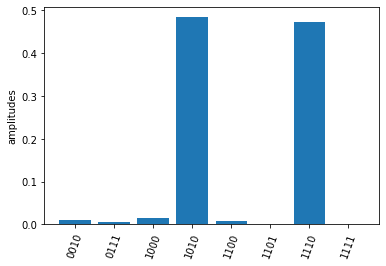

In [6]:
print(res.res) #counts
print(res.amplitudes) #amplitude
res.plot_amplitudes()

## Execute openqasm directly
Quafu provides from_openqasm() function for initializing quantum circuit directly from openqasm.

0 -H---*----*----*-- M->c[0]
       |    |    |  
1 -----+----|----|-- M->c[1]
            |    |  
2 ----------+----|-- M->c[2]
                 |  
3 ---------------+-- M->c[3]


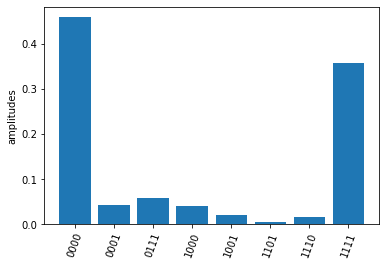

In [7]:
q = QuantumCircuit(4)
test_ghz = """OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
h q[0];
cx q[0],q[1];
cx q[0],q[2];
cx q[0],q[3];
"""
q.from_openqasm(test_ghz)
q.draw_circuit()
res = q.send()
res.plot_amplitudes()

## Execute circuit and measure observables

Quafu provides measuring observables with an excuted quantum circuit. You can input Pauli operators that need to expectation values to the submit_task() function.
For example, you can input [["XYX", [0, 1, 2]], ["Z", [1]]] to calcuate the expectation of operators $\sigma^x_0\sigma^y_1\sigma^x_2$ and $\sigma^z_1$.
The submit_task() function will minimize the executing times of the circuit with different measurement basis that can calculate all expectations of input operators. 

Here we show how to measure the energy expection of the Ising chain
$$H=\sum_i \sigma^z_i \sigma^z_{i+1} + g \sum_i \sigma^x_i.$$

First we initialize a circuit with three Hadamard gate

In [4]:
q = QuantumCircuit(5)

for i in range(5):
    if i % 2 == 0:
        q.h(i)

q.draw_circuit()
measures = list(range(5))
q.measure(measures, 2000)


0 -H- M->c[0]
     
1 --- M->c[1]
     
2 -H- M->c[2]
     
3 --- M->c[3]
     
4 -H- M->c[4]


Next we set operators that need to be measured to calculate the energy expectation, and submit the circuit using submit_task()

In [3]:
test_Ising = [["X", [i]] for i in range(5)]
test_Ising.extend([["ZZ", [i, i+1]] for i in range(4)])
res, obsexp = q.submit_task(test_Ising)

Job start, need measured in  [['XXXXX', [0, 1, 2, 3, 4]], ['ZZZZZ', [0, 1, 2, 3, 4]]]


The function return measurement results and operator expectations. The measurement results only contain two ExecResult object since the circuit is only executed twice, with measurement basis  [['XXXXX', [0, 1, 2, 3, 4]] and ['ZZZZZ', [0, 1, 2, 3, 4]]] respectively.

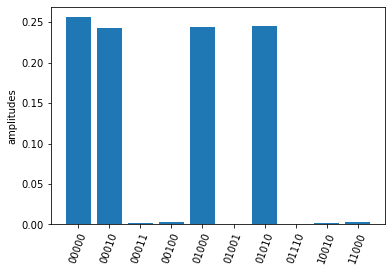

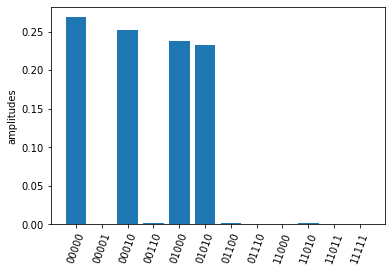

In [4]:

res[0].plot_amplitudes()
res[1].plot_amplitudes()


The return operator expectations (obsexp) is a list with a length equal to the input operator number. We can use it to calculate the energy expectation 

In [5]:
print(obsexp)
g = 0.5
E = g*sum(obsexp[:5])+sum(obsexp[5:])
print(E)


[0.9890000000000001, 0.010999999999999954, 0.9910000000000001, 0.016000000000000014, 0.9950000000000001, 0.05400000000000005, 0.04899999999999999, 0.02100000000000002, 0.019999999999999962]
1.645
